You will use the PyTorch library for all the classes and methods in this assignment. You should use a double-precision data type, and the device is either "CPU" or "cuda."

1) (4 points) Create your own PyTorch class that implements the method of SCAD regularization and variable selection (smoothly clipped absolute deviations) for linear models. Your development should be based on the following references:
https://andrewcharlesjones.github.io/journal/scad.html
https://www.jstor.org/stable/27640214?seq=1
Test your method on a real data set and determine a variable selection based on features' importance, according to SCAD.

In [100]:
import torch # we are going to use pytorch instead of numpy because it's much faster.
import torch.nn as nn
# from ignite.contrib.metrics.regression import R2Score
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.datasets import make_spd_matrix
from scipy.optimize import minimize
from scipy.linalg import toeplitz
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as R2

# from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
# from sklearn.model_selection import KFold, train_test_split as tts
# from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

In [101]:
device = torch.device("cpu")
dtype = torch.float64

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        """
        Compute the minimum and maximum value of the data for scaling.

        Args:
        - data (torch.Tensor): Input data tensor.
        """
        self.mean = torch.mean(data, dim=0, keepdim=True)
        self.std = torch.std(data, dim=0, keepdim=True)+1e-10

    def transform(self, data):
        """
        Scale the data based on the computed minimum and maximum values.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        if self.mean is None or self.std is None:
            raise ValueError("Scaler has not been fitted yet. Please call 'fit' with appropriate data.")

        scaled_data = (data - self.mean) / (self.std)
        return scaled_data

    def fit_transform(self, data):
        """
        Fit to data, then transform it.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        self.fit(data)
        return self.transform(data)

In [104]:
class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, data):
        """
        Compute the minimum and maximum value of the data for scaling.

        Args:
        - data (torch.Tensor): Input data tensor.
        """
        self.min = torch.min(data, dim=0, keepdim=True).values
        self.max = torch.max(data, dim=0, keepdim=True).values

    def transform(self, data):
        """
        Scale the data based on the computed minimum and maximum values.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        if self.min is None or self.max is None:
            raise ValueError("Scaler has not been fitted yet. Please call 'fit' with appropriate data.")

        scaled_data = (data - self.min) / (self.max - self.min)
        return scaled_data

    def fit_transform(self, data):
        """
        Fit to data, then transform it.

        Args:
        - data (torch.Tensor): Input data tensor.

        Returns:
        - torch.Tensor: Scaled data tensor.
        """
        self.fit(data)
        return self.transform(data)

In [105]:
def scad_penalty(beta_hat, lambda_val, alpha):
    beta_hat_abs = torch.abs(beta_hat)
    is_linear = (beta_hat_abs <= lambda_val).float()
    is_quadratic = ((lambda_val < beta_hat_abs) & (beta_hat_abs <= alpha * lambda_val)).float()
    is_constant = (alpha * lambda_val < beta_hat_abs).float()

    linear_part = lambda_val * beta_hat_abs * is_linear
    quadratic_part = ((2 * alpha * lambda_val * beta_hat_abs - beta_hat_abs**2 - lambda_val**2) / (2 * (alpha - 1))) * is_quadratic
    constant_part = (lambda_val**2 * (alpha + 1)) / 2 * is_constant

    return linear_part + quadratic_part + constant_part

In [106]:
class SCAD(nn.Module):
    def __init__(self, input_size, lambda_val=1.0, alpha=3.7):
        """
        Initialize the SCAD regression model.

        Args:
            input_size (int): Number of input features.
            lambda_val (float): Regularization strength.
            alpha (float): SCAD parameter that controls the non-convexity of the penalty.
        """
        super(SCAD, self).__init__()
        self.input_size = input_size
        self.lambda_val = lambda_val
        self.alpha = alpha

        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1,bias=False,device=device,dtype=dtype)

    def forward(self, x):
        """
        Forward pass of the SCAD model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).
        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the SCAD loss function with SCAD penalty.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The SCAD loss.
        """
        mse_loss = nn.functional.mse_loss(y_pred, y_true)
        scad_penalty_term = scad_penalty(self.linear.weight, self.lambda_val, self.alpha).sum()

        return mse_loss + scad_penalty_term

    def fit(self, X, y, num_epochs=100, learning_rate=1e-6):
        """
        Fit the SCAD model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.
        """
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()

            y_pred = self.forward(X)
            loss = self.loss(y_pred, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).
        """
        self.eval()
        with torch.no_grad():
            return self.forward(X)

    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).
        """
        return self.linear.weight.data


In [107]:
data = pd.read_csv('drive/MyDrive/cars.csv')

In [108]:
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [109]:
features = ["CYL", "ENG", "WGT"]
x = data.loc[:, ['CYL', 'ENG', 'WGT']].values
y = data['MPG'].values

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
xscaled = scale.fit_transform(x)

x_tensor = torch.tensor(x,device=torch.device("cpu"), dtype=torch.float64)
y_tensor  = torch.tensor(y,device=torch.device("cpu"),dtype=torch.float64)

# x.dtype
# y.shape

In [110]:
model = SCAD(input_size=x.shape[1], lambda_val=0.5, alpha = 3.7)
model.double()
model.fit(x_tensor, y_tensor)

Epoch [10/100], Loss: 1.0449122883476116e+28
Epoch [20/100], Loss: 1.7798787672164353e+53
Epoch [30/100], Loss: 3.0318032061787815e+78
Epoch [40/100], Loss: 5.164301552611428e+103
Epoch [50/100], Loss: 8.796748572582672e+128
Epoch [60/100], Loss: 1.4984172527668404e+154
Epoch [70/100], Loss: 2.552368349354934e+179
Epoch [80/100], Loss: 4.3476436077865425e+204
Epoch [90/100], Loss: 7.405672831315417e+229
Epoch [100/100], Loss: 1.2614647158810084e+255


In [111]:
model.get_coefficients()[0].cpu().detach().numpy()

array([-3.82656373e+122, -1.43957631e+124, -2.08509525e+125])

In [112]:
weights = np.abs(model.get_coefficients()[0].cpu().detach().numpy())
significant_features = np.where(weights > 0)[0]
for index in significant_features:
  print(features[index])

CYL
ENG
WGT


All features have some degree of importance in predicting the target variable.

2) (4 points) Based on the simulation design explained in class, generate 200 data sets where the input features have a strong correlation structure (you may consider a 0.9) and apply ElasticNet, SqrtLasso and SCAD to check which method produces the best approximation of an ideal solution, such as a "betastar" you design with a sparsity pattern of your choice.

In [113]:
class ElasticNet(nn.Module):
    def __init__(self, input_size, alpha=1.0, l1_ratio=0.5):
        """
        Initialize the ElasticNet regression model.

        Args:
            input_size (int): Number of input features.
            alpha (float): Regularization strength. Higher values of alpha
                emphasize L1 regularization, while lower values emphasize L2 regularization.
            l1_ratio (float): The ratio of L1 regularization to the total
                regularization (L1 + L2). It should be between 0 and 1.

        """
        super(ElasticNet, self).__init__()
        self.input_size = input_size
        self.alpha = alpha
        self.l1_ratio = l1_ratio

        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1,bias=False,device=device,dtype=dtype)

    def forward(self, x):
        """
        Forward pass of the ElasticNet model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the ElasticNet loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The ElasticNet loss.

        """
        mse_loss = nn.MSELoss()(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1)
        l2_reg = torch.norm(self.linear.weight, p=2)

        objective = (1/2) * mse_loss + self.alpha * (
            self.l1_ratio * l1_reg + (1 - self.l1_ratio) * (1/2)*l2_reg**2)

        return objective

    def fit(self, X, y, num_epochs=100, learning_rate=0.01):
        """
        Fit the ElasticNet model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight


In [114]:
# we can call this version PED_Adam because we use the adaptive momentum gradient descent for optimization
class sqrtLasso(nn.Module):
    def __init__(self, input_size, alpha=0.1):
        """
        Initialize the  regression model.


        """
        super(sqrtLasso, self).__init__()
        self.input_size = input_size
        self.alpha = alpha


        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1).double()

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The loss.

        """
        mse_loss = nn.MSELoss()(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1,dtype=torch.float64)
        # l2_reg = torch.norm(self.linear.weight, p=2,dtype=torch.float64)

        loss = (len(y_true)*mse_loss)**(1/2) + self.alpha * (l1_reg)

        return loss

    def fit(self, X, y, num_epochs=200, learning_rate=0.01):
        """
        Fit the model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight

In [115]:
# we want to define a function for generating x with a prescribed number of obsvervations, features and Toeplitz correlation structure.
# I made it output y values t000
def make_correlated_features(num_samples,p,rho):
  vcor = []
  for i in range(p):
    vcor.append(rho**i)
  r = toeplitz(vcor)
  mu = np.repeat(0,p)
  x = np.random.multivariate_normal(mu, r, size=num_samples)
  beta =np.array([-1,2,3,0,0,0,0,2,-1,4])
  beta = beta.reshape(-1,1)
  betastar = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)
  y = x@betastar + 1.5*np.random.normal(size=(n,1))
  return x, y

In [116]:
rho =0.7
p = 20
n = 150
vcor = []
for i in range(p):
  vcor.append(rho**i)

In [117]:
x, y = make_correlated_features(n,p,rho)

In [118]:
x

array([[ 0.176896  ,  1.15974615,  0.09768967, ...,  0.69135051,
         0.29657572, -0.1948872 ],
       [-0.06035153, -1.05750595, -1.19656044, ..., -0.12737915,
         0.43714357,  0.64943601],
       [ 1.1683986 ,  1.1616436 , -0.06956929, ..., -3.74427649,
        -1.94053538, -2.62084738],
       ...,
       [ 0.41850761,  0.13330002,  0.14927304, ...,  0.88074393,
        -1.34345057, -2.00237967],
       [-0.45004397,  0.33784594,  0.7900307 , ..., -0.01816749,
        -0.17188136, -0.23270693],
       [-0.73298395, -0.55966773, -1.06656216, ...,  0.79023784,
         1.73630037,  1.14721161]])

In [119]:
y

array([[ 2.43635287e+00],
       [ 9.89594155e-01],
       [ 7.24309193e-01],
       [ 1.73877321e+00],
       [-1.03082879e+01],
       [-9.92284669e+00],
       [ 1.17683540e+01],
       [ 1.78708961e+01],
       [ 6.80202536e+00],
       [ 3.39638431e+00],
       [ 6.28587216e+00],
       [-7.41465550e-01],
       [-7.03626030e+00],
       [ 3.03367953e+00],
       [-5.14923083e+00],
       [-1.07371611e+01],
       [ 1.10835680e+01],
       [-6.63516167e+00],
       [-3.01084370e+00],
       [ 2.51020699e+00],
       [ 5.64952532e+00],
       [-1.20548497e+00],
       [ 8.31168586e+00],
       [ 8.88938015e+00],
       [-3.06108336e+00],
       [-6.33794591e+00],
       [-9.27914443e+00],
       [-1.01042351e+01],
       [ 7.65473180e+00],
       [ 1.03624164e+00],
       [ 4.49800627e+00],
       [-6.42063509e-01],
       [ 1.27897217e+01],
       [-8.70509393e-01],
       [-6.60298175e+00],
       [ 1.65115017e+00],
       [-1.89298264e+00],
       [-1.58769317e+00],
       [-6.6

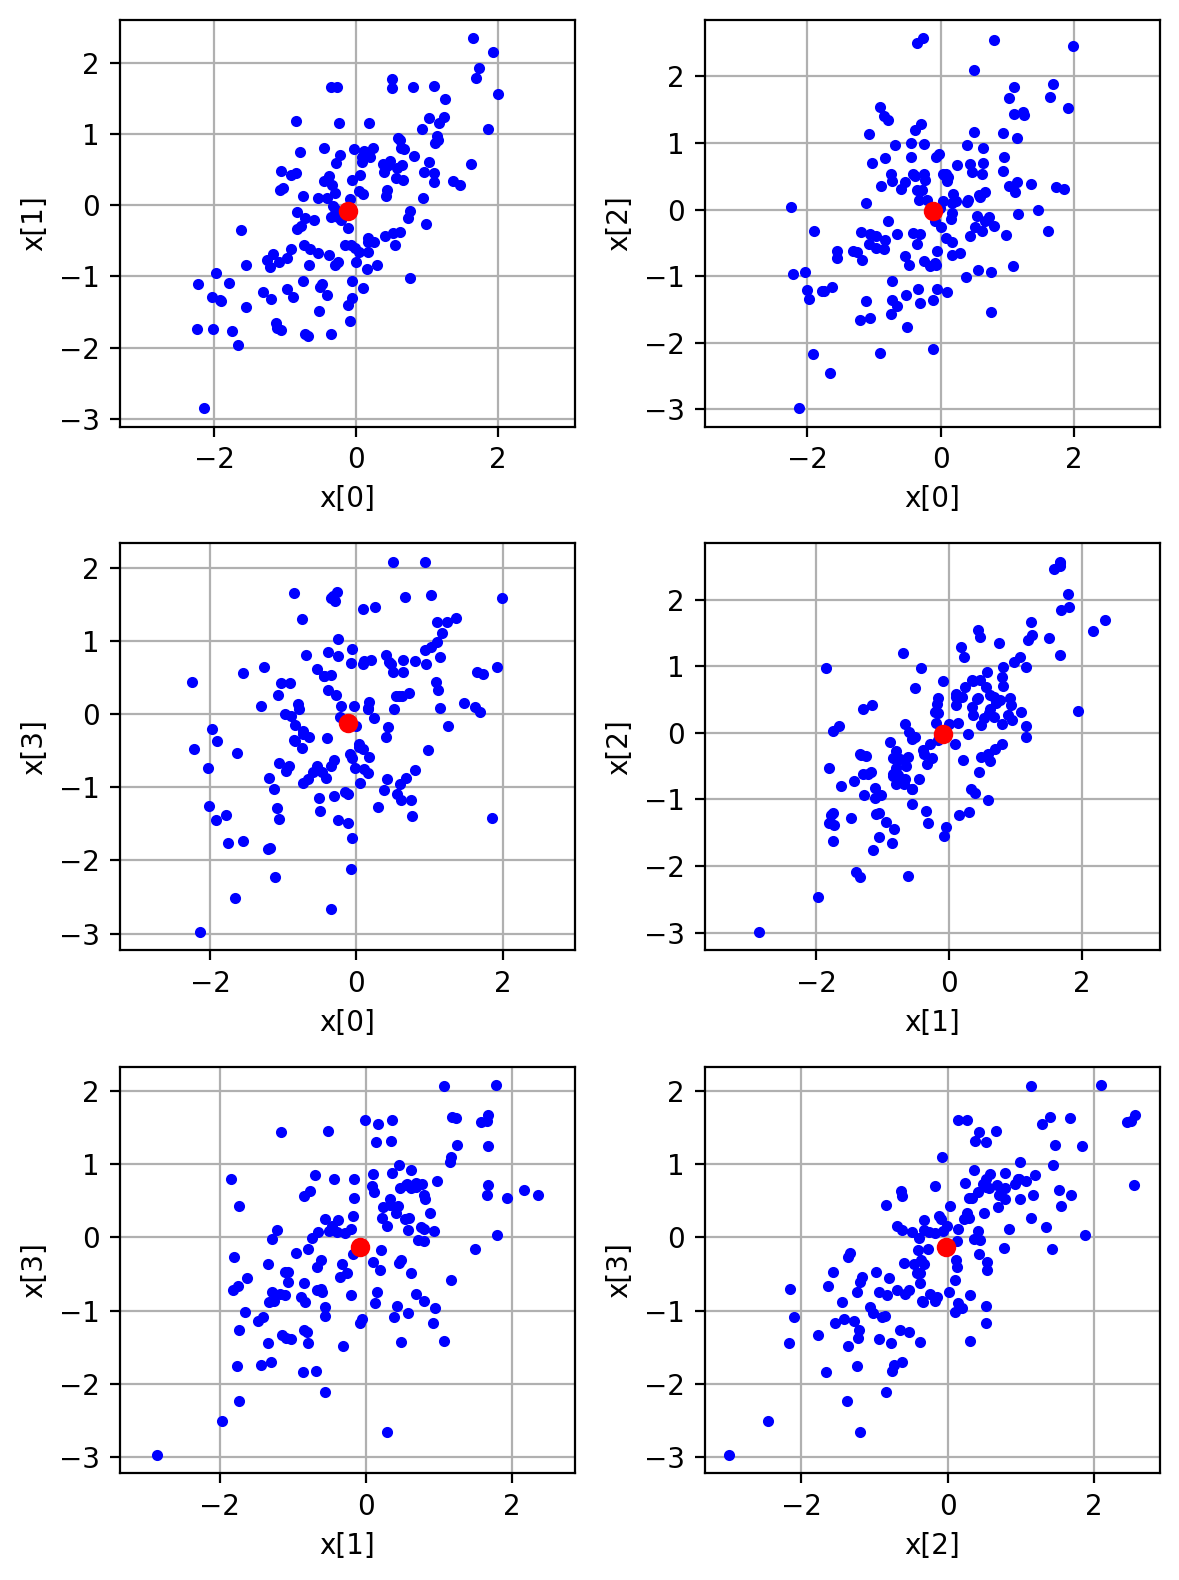

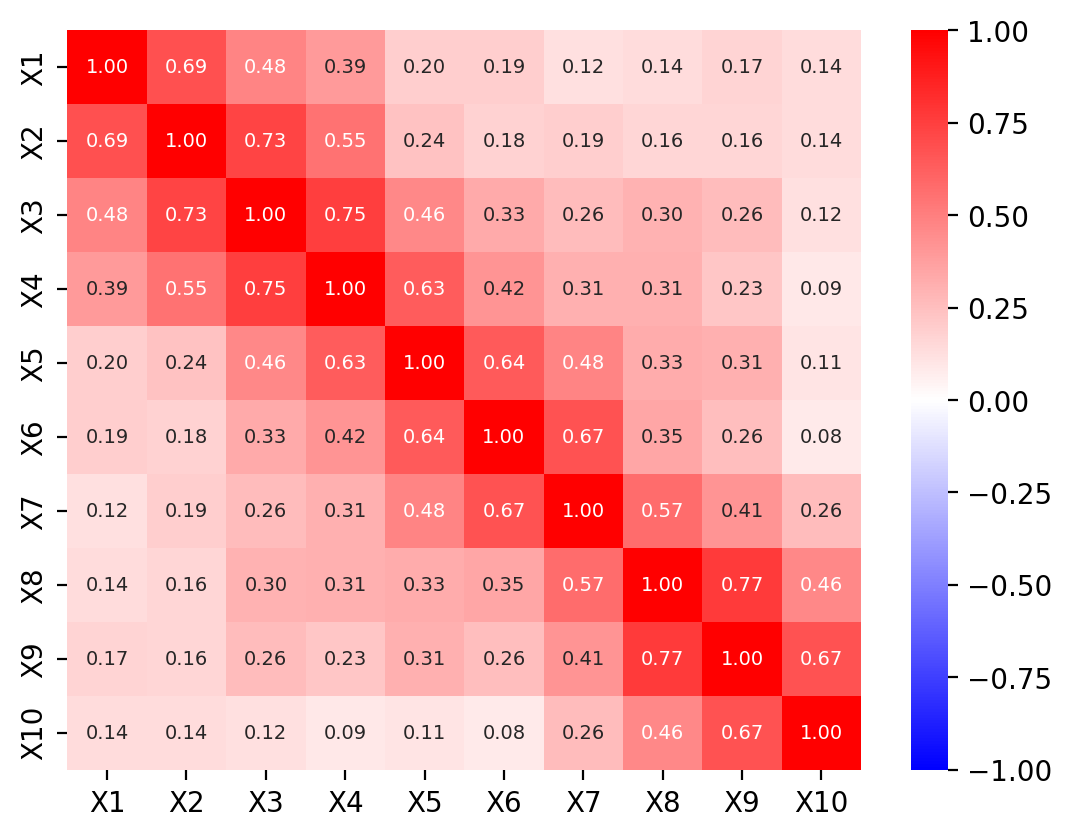

In [120]:

mu = np.mean(x,axis=0)

fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(6,8))


plt.subplot(3,2,1)
plt.plot(x[:,0], x[:,1], 'b.')
plt.plot(mu[0], mu[1], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(x[:,0], x[:,2], 'b.')
plt.plot(mu[0], mu[2], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(x[:,0], x[:,3], 'b.')
plt.plot(mu[0], mu[3], 'ro')
plt.xlabel('x[0]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(x[:,1], x[:,2], 'b.')
plt.plot(mu[1], mu[2], 'ro')
plt.xlabel('x[1]')
plt.ylabel('x[2]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(x[:,1], x[:,3], 'b.')
plt.plot(mu[1], mu[3], 'ro')
plt.xlabel('x[1]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(x[:,2], x[:,3], 'b.')
plt.plot(mu[2], mu[3
                   ], 'ro')
plt.xlabel('x[2]')
plt.ylabel('x[3]')
plt.axis('equal')
plt.grid(True)
fig.tight_layout()
plt.show()
cols = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']

# mind the transpose of x
# here we look at the correlations among the first 10 features
sns.heatmap(np.corrcoef(np.transpose(x[:,:10])),cmap='bwr',vmin=-1,vmax=1,annot=True,fmt='.2f',annot_kws={"size": 7},xticklabels=cols,yticklabels=cols)
plt.show()

In [122]:
rho =0.7
p = 20
n = 150
vcor = []
for i in range(p):
  vcor.append(rho**i)
beta =np.array([-1,2,3,0,0,0,0,2,-1,4])
beta = beta.reshape(-1,1)
betastar = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)

EN_errors = []
SL_errors = []
scad_errors = []

for _ in range(200):

  x, y = make_correlated_features(n,p,rho)
  if torch.cuda.is_available():
    device='cuda'
  else:
    device= 'cpu'

  x = torch.tensor(x,device=device)
  y = torch.tensor(y,device=device)

  #ElasticNet
  EN_model = ElasticNet(input_size=x.shape[1], alpha=0.1, l1_ratio=0.5)
  EN_model.fit(x, y, num_epochs=1000, learning_rate=0.01)
  beta_en = EN_model.get_coefficients().detach().numpy().flatten()
  EN_errors.append(mse(betastar, beta_en))

  #sqrtLasso
  SL_model=sqrtLasso(input_size=x.shape[1],alpha=0.1)
  SL_model.fit(x,y,num_epochs=1000,learning_rate=0.01)
  beta_sl = SL_model.get_coefficients().detach().numpy().flatten()
  SL_errors.append(mse(betastar, beta_sl))

  #SCAD
  scad_model = SCAD(input_size=x.shape[1],alpha=0.1)
  scad_model.fit(x, y)
  beta_scad = scad_model.get_coefficients().detach().numpy().flatten()
  scad_errors.append(mse(betastar, beta_scad))


Streaming output truncated to the last 5000 lines.
Epoch [100/1000], Loss: 39.585639226996406
Epoch [200/1000], Loss: 30.348076494709247
Epoch [300/1000], Loss: 25.74771601300196
Epoch [400/1000], Loss: 22.688878826701444
Epoch [500/1000], Loss: 21.02573726810601
Epoch [600/1000], Loss: 20.26056305156658
Epoch [700/1000], Loss: 19.9498328530347
Epoch [800/1000], Loss: 19.838315606433213
Epoch [900/1000], Loss: 19.798761467172067
Epoch [1000/1000], Loss: 19.785856056077
Epoch [10/100], Loss: 56.0837633825812
Epoch [20/100], Loss: 56.07537495815646
Epoch [30/100], Loss: 56.06698835423711
Epoch [40/100], Loss: 56.05860357038705
Epoch [50/100], Loss: 56.0502206061703
Epoch [60/100], Loss: 56.04183946115099
Epoch [70/100], Loss: 56.03346013489334
Epoch [80/100], Loss: 56.0250826269617
Epoch [90/100], Loss: 56.016706936920514
Epoch [100/100], Loss: 56.00833306433434
Epoch [100/1000], Loss: 3.77980838247218
Epoch [200/1000], Loss: 2.9344849870794993
Epoch [300/1000], Loss: 2.6222436131362494


In [124]:
print("ElasticNet mean error:", np.mean(EN_errors))
print("sqrtLasso mean error:", np.mean(SL_errors))
print("SCAD mean error:", np.mean(scad_errors))

ElasticNet mean error: 0.1222767241803727
sqrtLasso mean error: 0.038542253022587375
SCAD mean error: 1.7641556052495333


Of the three, sqrtLasso produces the best approximation of an ideal solution.

3) (2 points) Use the methods you implemented above to determine a variable selection for the Concrete data set with quadratic interaction terms (polynomial features of degree 2). To solve this, you should consider choosing the best weight for the penalty function. What is the ideal model size (number of variables with non-zero weights), and what is the cross-validated mean square error?

In [125]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

In [126]:
concrete = pd.read_csv('drive/MyDrive/concrete.csv')

In [127]:
concrete

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [128]:
x = concrete.iloc[:, :-1].values
y = concrete.iloc[:, -1].values

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(x)
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly) # Scaling
y = (y - y.mean()) / y.std()  # Standardize target

X_poly = torch.tensor(X_poly, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64).view(-1, 1)

In [129]:
kfold = KFold(n_splits=5, shuffle=True, random_state=22)

In [130]:
best_results = []

models = [
    {"type": ElasticNet, "name": "ElasticNet"},
    {"type": sqrtLasso, "name": "sqrtLasso"},
    {"type": SCAD, "name": "SCAD"}
]

for model_spec in models:
    best_mse = float('inf')
    best_alpha = None
    best_model_size = None

    for alpha in [0.01, 0.1, 1.0, 10.0]:
        mse_list = []
        model_sizes = []

        for train_idx, val_idx in kfold.split(X_poly):
            X_train, X_val = X_poly[train_idx], X_poly[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = model_spec["type"](input_size=X_poly.shape[1], alpha=alpha) #call the model with alpha
            model.fit(X_train, y_train, num_epochs=100, learning_rate=0.01)

            y_val_pred = model.predict(X_val) # evaluate with validation set
            mse = nn.functional.mse_loss(y_val_pred, y_val).item()
            mse_list.append(mse)

            non_zero_count = (model.get_coefficients().abs() > 1e-6).sum().item() # get coefficients
            model_sizes.append(non_zero_count)

        mean_mse = np.mean(mse_list)
        mean_model_size = np.mean(model_sizes)

        if mean_mse < best_mse:
            best_mse = mean_mse
            best_alpha = alpha
            best_model_size = mean_model_size

    best_results.append({
        "model_name": model_spec["name"],
        "best_alpha": best_alpha,
        "cross_validated_mse": best_mse,
        "ideal_model_size": best_model_size
    })


Epoch [100/100], Loss: 0.19143022442543725
Epoch [100/100], Loss: 0.17339434900747822
Epoch [100/100], Loss: 0.18561508693037665
Epoch [100/100], Loss: 0.170985357672946
Epoch [100/100], Loss: 0.17734086453022632
Epoch [100/100], Loss: 0.27807854741343513
Epoch [100/100], Loss: 0.27427880075245054
Epoch [100/100], Loss: 0.29372976152658137
Epoch [100/100], Loss: 0.2605929407005023
Epoch [100/100], Loss: 0.2730992986724443
Epoch [100/100], Loss: 0.5257279200161001
Epoch [100/100], Loss: 0.539010944629289
Epoch [100/100], Loss: 0.5431018873120256
Epoch [100/100], Loss: 0.5384670016571264
Epoch [100/100], Loss: 0.5358590415270947
Epoch [100/100], Loss: 5.493162099390279
Epoch [100/100], Loss: 6.299737851516819
Epoch [100/100], Loss: 6.0656481753073175
Epoch [100/100], Loss: 5.751321785589555
Epoch [100/100], Loss: 5.668609694273968
Epoch [100/100], Loss: 13.66837239128283
Epoch [100/100], Loss: 13.895404129600456
Epoch [100/100], Loss: 13.792486967563482
Epoch [100/100], Loss: 13.27235190

In [131]:
for result in best_results:
    print(f"Model: {result['model_name']}, Best Alpha: {result['best_alpha']}, "
          f"Cross-Validated MSE: {result['cross_validated_mse']}, "
          f"Ideal Model Size: {result['ideal_model_size']}")

Model: ElasticNet, Best Alpha: 0.01, Cross-Validated MSE: 0.32844020876997776, Ideal Model Size: 44.0
Model: sqrtLasso, Best Alpha: 0.1, Cross-Validated MSE: 0.2330405590433359, Ideal Model Size: 44.0
Model: SCAD, Best Alpha: 10.0, Cross-Validated MSE: 0.8801010317039673, Ideal Model Size: 44.0
